In [1]:
from utils import load_data, check_gpu, check_dir

import pandas as pd
import numpy as np
from tqdm import tqdm
import gc
from utils import meta_encoding
from functools import partial
import matplotlib.pyplot as plt
from scipy.stats import rankdata
import datetime
import lightgbm as lgb
pd.options.display.max_colwidth = 1000
pd.options.display.max_columns = 1000

%matplotlib inline
%load_ext autoreload
%autoreload 2
def fprint(df, name):
    print(f'{name} shape: ({df.shape[0]:,}, {df.shape[1]})')
import pprint
pp = pprint.PrettyPrinter(indent=1)

/Users/samshi/anaconda3/lib/python3.6/site-packages/lightgbm/__init__.py:46: UserWarning: Starting from version 2.2.1, the library file in distribution wheels for macOS is built by the Apple Clang (Xcode_8.3.3) compiler.
This means that in case of installing LightGBM from PyPI via the ``pip install lightgbm`` command, you don't need to install the gcc compiler anymore.
Instead of that, you need to install the OpenMP library, which is required for running LightGBM on the system with the Apple Clang compiler.
You can install the OpenMP library by the following command: ``brew install libomp``.
  "You can install the OpenMP library by the following command: ``brew install libomp``.", UserWarning)


In [170]:
nrow = 5000000
train_raw = load_data('train', nrows=nrow)
train_raw['timestamp'] = train_raw['timestamp'].apply(lambda ts: datetime.datetime.utcfromtimestamp(ts))


[25|13:30:35|utils              :114|load_data                |INFO] Loading train using 5,000,000 rows (4,999,976 trimmed) which is 31.38% out of total train data


In [3]:
train_ids = train_raw.session_id.unique()

In [4]:
# look at raw
rid = np.random.choice(train_ids, 1)[0]
rid

'297b3bd6ebf05'

### Check clean data

In [5]:
!ls cache

basic_preprocessed_train_1000000.snappy
basic_preprocessed_train_5000000.snappy
filters_mapping.npy
filters_selection_mapping.npy
meta_encodings.csv
preprocess_train_1000000_no_test_added.snappy
preprocess_train_5000000_no_test_added.snappy
train_inputs_5000000_no_test_added.snappy
train_inputs_lgb.snappy
train_inputs_nn.snappy


In [6]:
train_cleaned = pd.read_parquet(f'cache/preprocess_train_{nrow}_no_test_added.snappy')

In [7]:
train_ids = train_cleaned.session_id.unique()

problems: 'b160c4dab0582'

In [8]:
rid = np.random.choice(train_ids, 1)[0]
rid

'fedd288e697b1'

In [9]:
rid = 'b160c4dab0582'

In [10]:
# raw
raw_demo = train_raw[train_raw.session_id==rid].copy()
raw_demo

,user_id,session_id,timestamp,step,action_type,reference,platform,city,device,current_filters,impressions,prices
536613,IUTRZM8FH2T6,b160c4dab0582,2018-11-04 21:12:59,1,search for destination,"Santiago, Chile",CL,"Santiago, Chile",mobile,NaN,NaN,NaN
536614,IUTRZM8FH2T6,b160c4dab0582,2018-11-04 21:15:32,2,clickout item,3190210,CL,"Santiago, Chile",mobile,Focus on Distance,2087114|3190210|6731496|2085746|1246941|2804166|4936754|2397574|8469436|1391594|9998456|2864224|1553075|1386756|5218412|1869249|8342894|2125220|7805726|385656|1977695|4008420|2811784|2180452|2367190,39|28|35|34|37|41|44|39|36|29|44|39|44|37|39|39|41|41|42|36|40|35|44|43|41
536615,IUTRZM8FH2T6,b160c4dab0582,2018-11-04 21:20:19,3,search for poi,Centro Cultural Estación Mapocho,CL,"Santiago, Chile",mobile,Focus on Distance,NaN,NaN
536616,IUTRZM8FH2T6,b160c4dab0582,2018-11-04 21:20:46,4,clickout item,1391594,CL,"Santiago, Chile",mobile,Focus on Distance,1391594|4136940|1833567|1818699|3504242|2288920|7842692|1761035|5420338|4083196|1460411|4003902|3098376,29|30|26|29|28|28|31|24|31|30|10|32|21
536617,IUTRZM8FH2T6,b160c4dab0582,2018-11-04 21:22:47,5,clickout item,3098376,CL,"Santiago, Chile",mobile,Focus on Distance,1391594|4136940|1833567|1818699|3504242|2288920|7842692|1761035|5420338|4083196|1460411|4003902|3098376,29|30|26|29|28|28|31|24|31|30|10|32|21
536618,IUTRZM8FH2T6,b160c4dab0582,2018-11-04 21:24:00,6,clickout item,4083196,CL,"Santiago, Chile",mobile,Focus on Distance,1391594|4136940|1833567|1818699|3504242|2288920|7842692|1761035|5420338|4083196|1460411|4003902|3098376,29|30|26|29|28|28|31|24|31|30|10|32|21
536619,IUTRZM8FH2T6,b160c4dab0582,2018-11-04 21:25:27,7,interaction item deals,2288920,CL,"Santiago, Chile",mobile,NaN,NaN,NaN
536620,IUTRZM8FH2T6,b160c4dab0582,2018-11-04 21:25:47,8,interaction item image,2288920,CL,"Santiago, Chile",mobile,NaN,NaN,NaN
536621,IUTRZM8FH2T6,b160c4dab0582,2018-11-04 21:25:47,9,interaction item image,2288920,CL,"Santiago, Chile",mobile,NaN,NaN,NaN
536622,IUTRZM8FH2T6,b160c4dab0582,2018-11-04 21:25:47,10,interaction item image,2288920,CL,"Santiago, Chile",mobile,NaN,NaN,NaN


In [163]:
# clean
clean_demo = train_cleaned[train_cleaned.session_id==rid].copy()
clean_demo

,session_id,timestamp,step,action_type,current_filters,reference,impressions,prices,country,device,platform
1272506,fedd288e697b1,2018-11-03 17:02:56,1.0,1,None,Disneyland Paris,None,None,10,0,22
1272507,fedd288e697b1,2018-11-03 17:03:28,2.0,0,None,5005660,1473305|2450306|923601|883697|14082|5005660|99932|231736|1231946|341666|5125642|7768768|149255|8887828|6202520|13435|100023|14088|8471102|9336318|8207214|8461916|1161413|6398796|230041,119|72|110|99|125|96|142|75|72|53|95|193|122|184|182|117|247|81|181|172|106|112|66|118|78,10,0,22


### Check feature generations

In [164]:
train_inputs = pd.read_parquet('./cache/train_inputs_5000000_no_test_added.snappy')
cf_cols = [c for c in train_inputs.columns if 'current_filters' in c]
drop_cols = cf_cols  # + ['country', 'platform']
# drop cf col for now
train_inputs.drop(drop_cols, axis=1, inplace=True)

In [165]:
# # load model 
# clf = lgb.Booster(model_file='./models/lgb_cv0.model')

In [166]:
train_ids = train_inputs.session_id.unique()

In [173]:
rid = np.random.choice(train_ids, 1)[0]
rid

'e70c512fbd41e'

In [174]:
raw_display_cols = ['session_id', 'timestamp', 'step', 'action_type', 'reference', 'platform', 'city', 'device', 
                    'current_filters', 'impressions', 'prices']

In [175]:
raw_demo = train_raw[train_raw.session_id==rid].reset_index(drop=True)
click_mask = raw_demo.action_type=='clickout item'
answers = raw_demo.loc[click_mask, 'reference']
# raw_demo.loc[click_mask, 'reference'] = '?'
raw_demo[raw_display_cols]

,session_id,timestamp,step,action_type,reference,platform,city,device,current_filters,impressions,prices
0,e70c512fbd41e,2018-11-01 18:02:48,1,clickout item,5188048,HR,"Podgora, Croatia",mobile,NaN,5188048|3939444|5712352|7254410|88213|6556672|1359490|5762986|1896611|5619854|117666|2706928|1995125|3386335|2367838|4025622|3976024|1997621|2636438|2431363|6546918|2418382|4519484|4922540|8221960,47|63|58|900|90|40|68|43|14|30|36|50|48|110|85|36|79|70|78|135|15|188|35|75|40


In [181]:
prices = '47|63|58|900|90|40|68|43|14|30|36|50|48|110|85|36|79|70|78|135|15|188|35|75|40'.split('|')
prices = [float(p) for p in prices]

In [185]:
len(prices)

25

In [183]:
np.median(prices)

58.0

check input data with

In [176]:
input_demo = train_inputs[train_inputs.session_id==rid].reset_index(drop=True)
input_demo

,session_id,step,action_type,country,device,platform,fs,sort_order,imp_changed,session_size,session_duration,last_duration,last_action_type,last_reference_relative_loc,mean_rating,median_rating,std_rating,mean_star,median_star,std_star,impressions_str,n_imps,target,mean_price,median_price,std_price,n_cfs,prices_0,prices_1,prices_2,prices_3,prices_4,prices_5,prices_6,prices_7,prices_8,prices_9,prices_10,prices_11,prices_12,prices_13,prices_14,prices_15,prices_16,prices_17,prices_18,prices_19,prices_20,prices_21,prices_22,prices_23,prices_24,price_bin_0,price_bin_1,price_bin_2,price_bin_3,price_bin_4,price_bin_5,price_bin_6,price_bin_7,price_bin_8,price_bin_9,price_bin_10,price_bin_11,price_bin_12,price_bin_13,price_bin_14,price_bin_15,price_bin_16,price_bin_17,price_bin_18,price_bin_19,price_bin_20,price_bin_21,price_bin_22,price_bin_23,price_bin_24,prev_click_0,prev_click_1,prev_click_2,prev_click_3,prev_click_4,prev_click_5,prev_click_6,prev_click_7,prev_click_8,prev_click_9,prev_click_10,prev_click_11,prev_click_12,prev_click_13,prev_click_14,prev_click_15,prev_click_16,prev_click_17,prev_click_18,prev_click_19,prev_click_20,prev_click_21,prev_click_22,prev_click_23,prev_click_24,prev_interact_0,prev_interact_1,prev_interact_2,prev_interact_3,prev_interact_4,prev_interact_5,prev_interact_6,prev_interact_7,prev_interact_8,prev_interact_9,prev_interact_10,prev_interact_11,prev_interact_12,prev_interact_13,prev_interact_14,prev_interact_15,prev_interact_16,prev_interact_17,prev_interact_18,prev_interact_19,prev_interact_20,prev_interact_21,prev_interact_22,prev_interact_23,prev_interact_24,ratings_0,ratings_1,ratings_2,ratings_3,ratings_4,ratings_5,ratings_6,ratings_7,ratings_8,ratings_9,ratings_10,ratings_11,ratings_12,ratings_13,ratings_14,ratings_15,ratings_16,ratings_17,ratings_18,ratings_19,ratings_20,ratings_21,ratings_22,ratings_23,ratings_24,stars_0,stars_1,stars_2,stars_3,stars_4,stars_5,stars_6,stars_7,stars_8,stars_9,stars_10,stars_11,stars_12,stars_13,stars_14,stars_15,stars_16,stars_17,stars_18,stars_19,stars_20,stars_21,stars_22,stars_23,stars_24
0,e70c512fbd41e,1.0,0,47,0,49,33,8,NaN,1,0.0,NaN,10,NaN,2.92,3.0,0.844748,0.64,0.0,1.466424,5188048|3939444|5712352|7254410|88213|6556672|1359490|5762986|1896611|5619854|117666|2706928|1995125|3386335|2367838|4025622|3976024|1997621|2636438|2431363|6546918|2418382|4519484|4922540|8221960,25,0,97.32,58.0,168.073965,0.0,47.0,63.0,58.0,900.0,90.0,40.0,68.0,43.0,14.0,30.0,36.0,50.0,48.0,110.0,85.0,36.0,79.0,70.0,78.0,135.0,15.0,188.0,35.0,75.0,40.0,1,2,2,4,4,1,2,1,0,0,0,2,2,4,3,0,3,3,3,4,0,4,0,3,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.5,0.75,0.5,0.75,0.75,0.75,1.0,1.0,0.25,0.5,0.75,0.75,0.5,1.0,0.75,0.75,0.75,0.75,0.75,1.0,0.75,0.75,0.75,1.0,0.75,1.0,0.5,1.0,0.5,1.0,0.5,1.0,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5


In [189]:
pd.qcut([1,2,3], q=3).codes+1

array([1, 2, 3], dtype=int8)

In [180]:
pprint.pprint(input_demo.to_dict(orient='list'))

{'action_type': [0],
 'country': [47],
 'device': [0],
 'fs': [33],
 'imp_changed': [nan],
 'impressions_str': ['5188048|3939444|5712352|7254410|88213|6556672|1359490|5762986|1896611|5619854|117666|2706928|1995125|3386335|2367838|4025622|3976024|1997621|2636438|2431363|6546918|2418382|4519484|4922540|8221960'],
 'last_action_type': [10],
 'last_duration': [nan],
 'last_reference_relative_loc': [nan],
 'mean_price': [97.32],
 'mean_rating': [2.92],
 'mean_star': [0.64],
 'median_price': [58.0],
 'median_rating': [3.0],
 'median_star': [0.0],
 'n_cfs': [0.0],
 'n_imps': [25],
 'platform': [49],
 'prev_click_0': [nan],
 'prev_click_1': [nan],
 'prev_click_10': [nan],
 'prev_click_11': [nan],
 'prev_click_12': [nan],
 'prev_click_13': [nan],
 'prev_click_14': [nan],
 'prev_click_15': [nan],
 'prev_click_16': [nan],
 'prev_click_17': [nan],
 'prev_click_18': [nan],
 'prev_click_19': [nan],
 'prev_click_2': [nan],
 'prev_click_20': [nan],
 'prev_click_21': [nan],
 'prev_click_22': [nan],
 'p

In [ ]:
s = '44|65|30|47|43|33|41|102|95|112|6|62|40|78|30|66|66|123|61|33|68|89|177|44|49'
s = s.split('|')
s = [float(i) for i in s]
rankdata(s, method='dense'), rankdata(s, method='dense').max()

In [ ]:
train_inputs.sort_order.unique()

In [ ]:
pp.pprint(input_demo.to_dict())

In [ ]:
shap_values[0].shape

In [ ]:
ps = '220|193|310|265|162|119|99|43|51|83|96|65'.split('|')
ps = [float(i) for i in ps]
rankdata(ps, method='dense')

In [ ]:
np.nanmean(ps), np.nanmedian(ps), np.mean(ps), np.median(ps)

In [ ]:
1/12

In [ ]:
2/25

In [ ]:
meta_mapping = meta_encoding()

In [ ]:
# refs = raw_eg.impressions.dropna().str.split('|')
# refs = list([int(j) for i in refs for j in i])
refs = '20720|20814|83606|20772|20752|45909|9844958|20861|20681|45379|2085654|20785|152418|20848|20736|20750|20949|20743|917187|20745|20677|905283|83339|20843|20819'
refs = refs.split('|')
refs = [int(i) for i in refs]

In [ ]:
refs_meta = meta_mapping[meta_mapping.item_id.isin(refs)]
s = refs_meta.sum(axis=0)
refs_meta_useful = refs_meta[s[s!=0].index].reset_index(drop=True)
ss = refs_meta_useful.sum(axis=0)
refs_meta_useful = refs_meta_useful[ss[ss!=24].index]
refs_meta_useful = refs_meta_useful.set_index('item_id')
refs_meta_useful = refs_meta_useful.reindex(refs)
# cols = ['1 star', '2 star', '3 star', '4 star', '5 star', 
#                   'excellent rating', 'very good rating', 'good rating', 'satisfactory rating']
# refs_meta_useful[[c for c in cols if c in refs_meta_useful.columns]].loc[refs]
refs_meta_useful

In [ ]:
(6*4+3*2+2+1)/12, (1+4+4+1+3+2+0+0+2+3+3)/12

### check the meta properties

In [ ]:
meta_mapping = meta_encoding()

In [ ]:
# refs = raw_eg.impressions.dropna().str.split('|')
# refs = list([int(j) for i in refs for j in i])
refs = '14910|52419|53438|15918|15402|128443|772473|626051|158537|1193842|14824|5179324'
refs = refs.split('|')
refs = [int(i) for i in refs]

In [ ]:
refs_meta = meta_mapping[meta_mapping.item_id.isin(refs)]
s = refs_meta.sum(axis=0)
refs_meta_useful = refs_meta[s[s!=0].index].reset_index(drop=True)
ss = refs_meta_useful.sum(axis=0)
refs_meta_useful = refs_meta_useful[ss[ss!=24].index]
refs_meta_useful = refs_meta_useful.set_index('item_id')
refs_meta_useful = refs_meta_useful.reindex(refs)
refs_meta_useful

In [ ]:
cols_sum = refs_meta_useful.sum(axis=0)
one_cols = cols_sum[cols_sum==1].index
refs_meta_useful[one_cols]

In [ ]:
meta_mapping[meta_mapping.item_id==110702]

In [ ]:
m = pd.read_csv('./data/item_metadata.csv')

In [ ]:
m[m.item_id==110702]

In [ ]:
meta_mapping.columns.values

In [ ]:
meta_mapping[['1 star', '2 star', '3 star', 'from 3 stars', '4 star', 'from 4 stars', '5 star']]

In [ ]:
meta_mapping[['satisfactory rating', 'good rating', 'very good rating', 'excellent rating']]

In [ ]:
meta_mapping.head()

In [ ]:
(meta_mapping.loc[meta_mapping['good rating']==1, 'satisfactory rating']==0).sum()

In [ ]:
81/187

In [ ]:
1/25

In [ ]:
s = '81|120|81|187|70|45|56|130|124|56|58|77|52|40|120|53|65|65|54|30|59|33|45|108|37'
s = s.split('|')
s = [int(i) for i in s]
from scipy.stats import rankdata
rankdata(s, method='dense')

In [ ]:
17/20

In [ ]:
# input_demo = train_inputs[train_inputs.session_id==rid].reset_index(drop=True)
# input_demo

In [ ]:
# pp.pprint(input_demo.to_dict(orient='list'))

In [ ]:
from create_model_inputs import change_sort_order_mapping
change_sort_order_mapping()

### look at feature distribution

In [72]:
def check_distribution(rcol, bins=100, density=True, log=False, each_class=True):
    if each_class:
        demo = train_inputs[[rcol, 'target']]
        grps = demo.groupby('target')
        plt.clf()
        cm = plt.get_cmap('gist_rainbow')
        fig = plt.figure()
        ax = fig.add_subplot(111)
        ax.set_prop_cycle(color=[cm(1.*i/NUM_COLORS) for i in range(NUM_COLORS)])
        for k, grp in grps:
            _ = grp[rcol].hist(density=density, bins=bins, alpha=0.3, figsize=(20,10), label=f'{k}', ax=ax)
        plt.suptitle(f'{rcol} histgram')
        _ = plt.legend()
    else:
        ax = train_inputs[rcol].hist(density=density, bins=bins)
        plt.suptitle(f'{rcol} histgram')
    if log:
        ax.set_yscale('log')

In [8]:
columns = train_inputs.columns.values

In [79]:
columns

array(['session_id', 'step', 'device', 'fs', 'sort_order', 'imp_changed',
       'session_size', 'session_duration', 'last_duration',
       'last_action_type', 'last_reference_relative_loc', 'mean_rating',
       'median_rating', 'mean_star', 'median_star', 'n_imps', 'target',
       'mean_price', 'median_price', 'prices_0', 'prices_1', 'prices_2',
       'prices_3', 'prices_4', 'prices_5', 'prices_6', 'prices_7',
       'prices_8', 'prices_9', 'prices_10', 'prices_11', 'prices_12',
       'prices_13', 'prices_14', 'prices_15', 'prices_16', 'prices_17',
       'prices_18', 'prices_19', 'prices_20', 'prices_21', 'prices_22',
       'prices_23', 'prices_24', 'prices_rank_0', 'prices_rank_1',
       'prices_rank_2', 'prices_rank_3', 'prices_rank_4', 'prices_rank_5',
       'prices_rank_6', 'prices_rank_7', 'prices_rank_8', 'prices_rank_9',
       'prices_rank_10', 'prices_rank_11', 'prices_rank_12',
       'prices_rank_13', 'prices_rank_14', 'prices_rank_15',
       'prices_rank_16', 'pr

In [12]:
# nan_cols = train_inputs.isna().sum()
# nan_cols[nan_cols>0]#.plot.bar()

In [99]:
rcol = np.random.choice(columns, 1)[0] 
rcol = 'n_imps'
rcol

'n_imps'

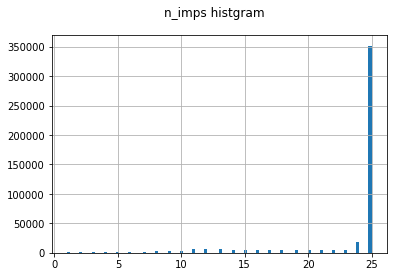

In [100]:
check_distribution(rcol, bins=100, log=False, density=False, each_class=False)

<Figure size 432x288 with 0 Axes>

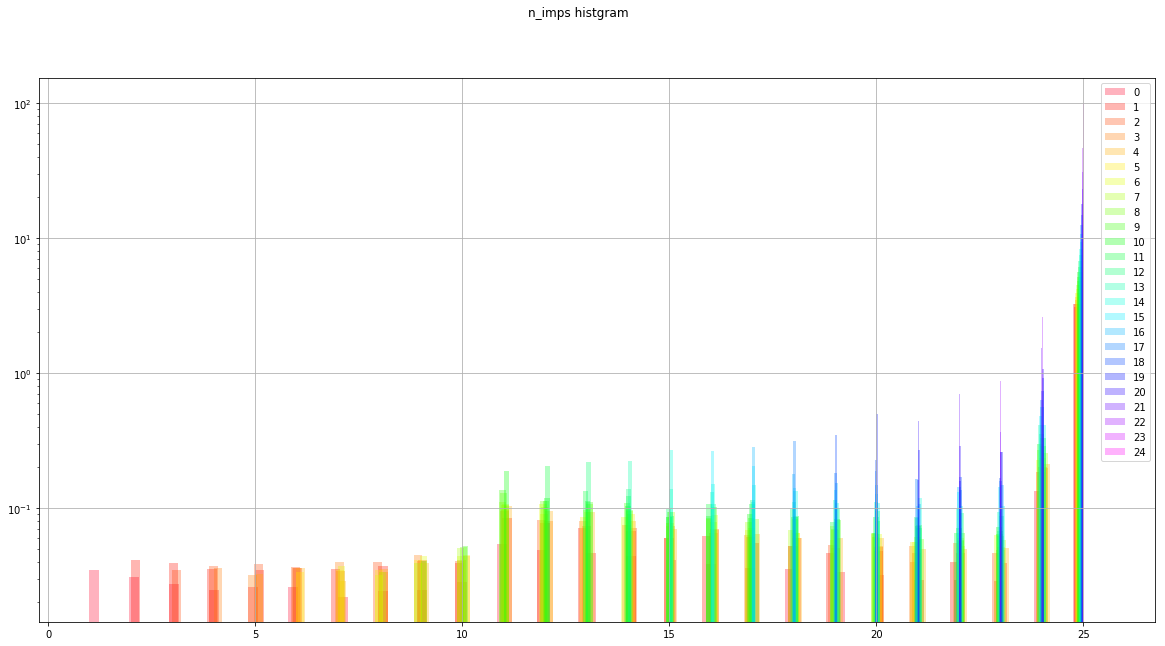

In [101]:
check_distribution(rcol, bins=100, log=True, density=True, each_class=True)

In [89]:
# train_inputs[rcol].hist(density=True, bins=50)

### Look at nn inputs

In [9]:
nn_inputs = pd.read_parquet('./cache/train_inputs_nn.snappy')

In [12]:
nn_inputs.head()

,session_id,step,action_type,device,imp_changed,session_size,session_duration,last_duration,last_reference_relative_loc,mean_rating,median_rating,std_rating,mean_star,median_star,std_star,n_imps,target,mean_price,median_price,std_price,n_cfs,prices_0,prices_1,prices_2,prices_3,prices_4,prices_5,prices_6,prices_7,prices_8,prices_9,prices_10,prices_11,prices_12,prices_13,prices_14,prices_15,prices_16,prices_17,prices_18,prices_19,prices_20,prices_21,prices_22,prices_23,prices_24,prev_click_0,prev_click_1,prev_click_2,prev_click_3,prev_click_4,prev_click_5,prev_click_6,prev_click_7,prev_click_8,prev_click_9,prev_click_10,prev_click_11,prev_click_12,prev_click_13,prev_click_14,prev_click_15,prev_click_16,prev_click_17,prev_click_18,prev_click_19,prev_click_20,prev_click_21,prev_click_22,prev_click_23,prev_click_24,prev_interact_0,prev_interact_1,prev_interact_2,prev_interact_3,prev_interact_4,prev_interact_5,prev_interact_6,prev_interact_7,prev_interact_8,prev_interact_9,prev_interact_10,prev_interact_11,prev_interact_12,prev_interact_13,prev_interact_14,prev_interact_15,prev_interact_16,prev_interact_17,prev_interact_18,prev_interact_19,prev_interact_20,prev_interact_21,prev_interact_22,prev_interact_23,prev_interact_24,ratings_0,ratings_1,ratings_2,ratings_3,ratings_4,ratings_5,ratings_6,ratings_7,ratings_8,ratings_9,ratings_10,ratings_11,ratings_12,ratings_13,ratings_14,ratings_15,ratings_16,ratings_17,ratings_18,ratings_19,ratings_20,ratings_21,ratings_22,ratings_23,ratings_24,stars_0,stars_1,stars_2,stars_3,stars_4,stars_5,stars_6,stars_7,stars_8,stars_9,stars_10,stars_11,stars_12,stars_13,stars_14,stars_15,stars_16,stars_17,stars_18,stars_19,stars_20,stars_21,stars_22,stars_23,stars_24,last_action_type_0,last_action_type_1,last_action_type_2,last_action_type_3,last_action_type_4,last_action_type_5,last_action_type_6,last_action_type_7,last_action_type_8,last_action_type_9
0,0000d4284ff9b,-0.223144,0,0,-1.0,0.000000,0.608351,-0.405465,0.04,2.880000,3.0,0.863481,1.680000,2.0,1.690444,0.000000,0,-0.072226,-0.128381,0.057811,0.0,72.0,60.0,93.0,67.0,49.0,182.0,112.0,52.0,97.0,181.0,126.0,120.0,157.0,126.0,104.0,39.0,94.0,60.0,25.0,68.0,53.0,48.0,62.0,52.0,79.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.693147,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.75,0.500000,1.0,0.500000,0.500000,1.000000,0.500000,0.500000,1.000000,1.0,0.75,0.5,1.0,0.75,0.75,0.5,0.75,0.75,0.25,0.75,0.75,0.5,1.0,1.0,0.75,0.25,0.250000,0.250000,0.250000,0.250000,1.000000,0.750000,0.250000,0.250000,1.000000,1.000000,0.750000,1.000000,1.000000,0.750000,0.75,0.75,0.25,0.5,0.25,0.5,0.25,0.25,0.25,0.75,0,0,1,0,0,0,0,0,0,0
1,00030e90e12b2,-0.916291,0,2,-1.0,-0.693147,-4.812184,-3.178054,0.00,1.555556,0.0,1.770820,0.888889,0.0,1.728483,-0.955511,0,0.587484,0.536986,0.879628,0.0,433.0,180.0,124.0,168.0,153.0,141.0,115.0,106.0,105.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.00,0.666667,1.0,0.666667,0.333333,0.333333,0.333333,0.333333,0.333333,0.0,0.00,0.0,0.0,0.00,0.00,0.0,0.00,0.00,0.00,0.00,0.00,0.0,0.0,0.0,0.00,1.00,0.666667,0.333333,0.333333,0.333333,0.333333,0.333333,0.333333,0.333333,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,0.00,0.00,0.0,0.00,0.0,0.00,0.00,0.00,0.00,0,0,0,0,0,0,0,0,0,1
2,00030e90e12b2,-0.510826,0,2,0.0,-0.287682,-0.139356,1.494775,0.04,1.555556,0.0,1.770820,0.888889,0.0,1.728483,-0.955511,1,0.587484,0.536986,0.879628,0.0,433.0,180.0,124.0,168.0,153.0,141.0,115.0,106.0,105.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.693147,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0

In [45]:
def log_median(df, col=None):
    if col is None:
        return np.log((1+df)/(1+np.median(df)))
    else:
        return np.log((1+df[col])/(1+np.median(df[col])))
    
def standerize(df, col=None):
    if col is None:
        m = df.mean()
        std = df.std()
        return (df-m)/std
    else:
        m = df[col].mean()
        std = df[col].std()
        return (df[col]-m)/std

In [48]:
def plot_hist(df_nn, df_input, col, bins=[100, 100]):
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 6))
#     _ = log_median(df_input, col).hist(bins=bins[1], ax=axes[1])    
    _ = df_input[col].hist(bins=bins[0], ax=axes[0])    
    _ = df_nn[col].hist(bins=bins[1], ax=axes[1])


In [50]:
# some transformation
to_log_median_cols = ['last_duration', 'session_duration', 'session_size', 'n_imps',
                      'mean_price', 'median_price', 'std_price', 'n_cfs',
                      'step']
prev_cols = [i for i in train_inputs.columns if 'prev' in i]
to_log_median_cols.extend(prev_cols)

In [76]:
def check_cols():
    for c in to_log_median_cols:
        yield c
check = check_cols()

In [160]:
# c = next(check)
# c

In [161]:
c = 'last_reference_relative_loc'

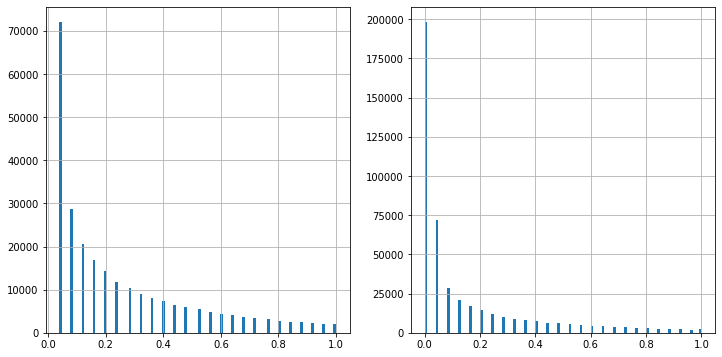

In [162]:
plot_hist(nn_inputs, train_inputs, c, bins=[100, 100])

In [63]:
train_inputs.n_imps.unique()

array([25,  9, 15,  4, 24, 11, 13, 12, 18, 14,  7, 16, 17,  5, 19, 20, 22,
        2, 10,  8, 21,  3,  6, 23,  1])

In [67]:
np.median(train_inputs[c])

25.0

In [66]:
log_median(train_inputs, c)

0         0.000000
1        -0.955511
2        -0.955511
3        -0.955511
4        -0.485508
5         0.000000
6         0.000000
7         0.000000
8         0.000000
9        -1.648659
10        0.000000
11        0.000000
12        0.000000
13        0.000000
14        0.000000
15        0.000000
16       -0.039221
17        0.000000
18        0.000000
19        0.000000
20       -1.648659
21       -1.648659
22       -0.773190
23       -0.619039
24        0.000000
25       -0.039221
26        0.000000
27        0.000000
28       -0.039221
29        0.000000
            ...   
453157    0.000000
453158    0.000000
453159    0.000000
453160    0.000000
453161   -0.860201
453162   -0.860201
453163    0.000000
453164    0.000000
453165    0.000000
453166    0.000000
453167   -0.693147
453168    0.000000
453169    0.000000
453170    0.000000
453171   -0.039221
453172    0.000000
453173    0.000000
453174    0.000000
453175    0.000000
453176    0.000000
453177    0.000000
453178    0.

### country related

In [ ]:
cp = load_data('train', usecols=['city', 'platform'])

In [ ]:
cp['country'] = cp['city'].str.split(', ').str[-1]
cp['country'] = cp['country'].str.lower()

In [ ]:
countries = cp['country'].unique()

In [ ]:
platforms = cp['platform'].unique()

In [ ]:
country2code = np.load('data/country2code.npy').item()

In [ ]:
code2country = np.load('data/code2country.npy').item()

In [ ]:
set(countries) - set(list(country2code.keys()))

In [ ]:
set(list(country2code.keys())) - set(countries)

In [ ]:
fix_dict = {'bermudas': 'bermuda', 
            'bes islands': None,
            'brunei':'brunei darussalam',
            'china': "people's republic of china",
            'crimea': None,
            'curacao': 'netherlands antilles',
            'democratic republic of congo': 'congo, the democratic republic of',
            'east timor': 'timor',
            'french antilles': None,
            'guinea-bissau': None,
            'iran': 'iran, islamic republic of',
            'ivory coast': "côte d'ivoire",
            'kosovo': None,
            'laos': "lao people's democratic republic"
           }

In [ ]:
train_raw.impressions.notna()[train_raw.impressions.notna()].index[0]

In [ ]:
a = pd.read_parquet('./gbm_cache/preprocess_train_5000000_test_added.snappy')

In [ ]:
a.reference.head()

In [ ]:
a.reference.isna().sum()

In [ ]:
a[a.reference.isna()]

In [ ]:
b = pd.read_csv('./data/test.csv')

In [ ]:
b[b.session_id=='2a181b2125efe']

In [ ]:
import datetime
b['timestamp'] = b['timestamp'].apply(lambda ts: datetime.datetime.utcfromtimestamp(ts))


In [ ]:
b.timestamp

In [ ]:
a = pd.DataFrame({'A': np.random.randint(0, 3 ,10), 'B': np.random.randint(0, 5 ,10)})
a.loc[np.random.choice(a.index, 3), 'B'] = np.nan
a

In [ ]:
c = a.groupby('A')['B'].apply(list).reset_index()
c

In [ ]:
c.reset_index().B.values.tolist()

In [ ]:
m = {0: 'E', 1: 'Q'}
a.A.map(m)